In [1]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, img_ch, num_classes, image_size=32):
        super(Discriminator, self).__init__()
        self.img_ch = img_ch
        self.num_classes = num_classes
        self.image_size = image_size
        # input size: 1*32*32
        self.label_embedding = nn.Embedding(num_classes, self.image_size*self.image_size)
        
        self.discriminate = nn.Sequential(
            nn.Conv2d(img_ch+1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, input, label):
        x_lbl = self.label_embedding(label)
        x_lbl = x_lbl.reshape([x_lbl.shape[0], 1, self.image_size, self.image_size])
        x = torch.cat((input, x_lbl), dim=1)
        x = self.discriminate(x)
        #print(x.shape)
        return x.squeeze()


class Generator(nn.Module):
    def __init__(self, in_channel, num_classes, img_ch):
        super(Generator, self).__init__()
        self.num_classes = num_classes
        label_embed_size = 5
        # input size: c*1*1
        self.label_embedding = nn.Embedding(num_classes, label_embed_size)

        self.generate = nn.Sequential(
            nn.ConvTranspose2d(in_channel+label_embed_size, 256, 4, 2, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, img_ch, 4, 2, 1, bias=False),
            nn.Tanh()
        )


  
    def forward(self, input, label):
        x_lbl = self.label_embedding(label)
        x_lbl = x_lbl.reshape([x_lbl.shape[0], -1, 1, 1])
        x = torch.cat((input, x_lbl), dim=1)
        return self.generate(x)


In [18]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

class Network():
    def __init__(self, latent_dims=64, num_epochs=50, batch_size=256, learning_rate=2.0e-4, dataset='cifar10', gpu=True):
        self.latent_dims = latent_dims
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.in_channel = 10
        if dataset == 'mnist' or dataset == 'fashion_mnist':
            self.img_ch = 1
        else:
            self.img_ch = 3

        self.num_classes = 10
        self.learning_rate = learning_rate
        self.gpu = gpu
        self.dur_time = 0

        self._init_dataset()
        self._init_model()

    def _init_dataset(self):
        transform = transforms.Compose([
              transforms.Resize(32),
              transforms.ToTensor(), 
              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

        train_data = CIFAR10(root='./dataset_cifar10', download=True, train=True, transform=transform)
        test_data = CIFAR10(root='./dataset_cifar10', download=True, train=False, transform=transform)

        self.train_queue = data.DataLoader(train_data, batch_size=self.batch_size, shuffle=True, drop_last=True)
        self.test_queue = data.DataLoader(test_data, batch_size=self.batch_size, shuffle=True, drop_last=True)

    def _weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

    def _init_model(self):
        self.device = torch.device('cuda' if (torch.cuda.is_available() & self.gpu) else 'cpu')

        Gen = Generator(self.in_channel, self.num_classes, self.img_ch).to(self.device)
        Dis = Discriminator(self.img_ch, self.num_classes).to(self.device)
        self.Gen = Gen.to(self.device)
        self.Dis = Dis.to(self.device)

        self.Gen.apply(self._weights_init)
        self.Dis.apply(self._weights_init)

        self.criterion = nn.BCELoss()

        #self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=self.learning_rate, weight_decay=1e-5)
        self.G_optimizer = optim.Adam(self.Gen.parameters(), lr=self.learning_rate, betas=(0.5, 0.999), weight_decay=2e-5)    # optimizer
        self.D_optimizer = optim.Adam(self.Dis.parameters(), lr=self.learning_rate, betas=(0.5, 0.999), weight_decay=2e-5)

    def generate_imgs(self, z, fixed_label, epoch=0, num_images=20):
        samples_path = os.path.join('./samples2/CIFAR10')
        if not os.path.exists(samples_path):
            os.makedirs(samples_path)
            
        self.Gen.eval()
        fake_imgs = self.Gen(z, fixed_label)
        fake_imgs = (fake_imgs + 1) / 2
        fake_imgs_ = vutils.make_grid(fake_imgs, normalize=False, nrow=20)
        vutils.save_image(fake_imgs_, os.path.join(samples_path, 'sample_' + str(epoch) + '.png'))
        
        fake_imgs = fake_imgs.detach().cpu()
        for index, img in enumerate(fake_imgs):
            if index < num_images:
                plt.subplot(2, 10, index+1)
                plt.imshow(img.permute(1, 2, 0))
                plt.axis('off')

    def calc_time(self, seconds):
        m, s = divmod(seconds, 60)
        h, m = divmod(m, 60)
        t, h = divmod(h, 24)
        return {'day':t, 'hour':h, 'minute':m, 'second':int(s)}


    def train_cifar10(self):
        G_loss_list = []
        D_loss_list = []
        run_start = time.time()

        self.Gen.train()
        self.Dis.train()
        for epoch in range(self.num_epochs):
            G_loss_sum = 0
            D_loss_sum = 0

            show_inputs = None
            show_outputs = None
            for step, (inputs, labels) in enumerate(self.train_queue):
                self.D_optimizer.zero_grad()

                inputs_real = inputs.to(self.device) # 64,1,32,32
                labels = labels.to(self.device)
                noise = torch.tensor(torch.randn(self.batch_size, self.in_channel, 1, 1, device=self.device)) # torch.Size([64, 100, 1, 1])
                
                # Generate fake data
                #x_fake = gen(z_fake, x_label)
                fake_out = self.Gen(noise, labels)
                
                real_label = torch.ones(self.batch_size,).to(self.device) # 64個1，代表真實的圖片
                fake_label = torch.zeros(self.batch_size,).to(self.device)   # 64個0，代表假的圖片
                
                # Train Discriminator
                fake_predict = self.Dis(fake_out.detach(), labels)
                inputs_real_predict = self.Dis(inputs_real.detach(), labels)
                D_loss = (self.criterion(fake_predict, fake_label) + self.criterion(inputs_real_predict, real_label)) / 2
                
                D_loss.backward()
                self.D_optimizer.step()

                D_loss_list.append(D_loss.item())
                D_loss_sum += D_loss

                self.G_optimizer.zero_grad()

                # 訓練生成真實圖片
                fake_predict2 = self.Dis(fake_out, labels)  # 獲得Discriminator的判斷
                G_loss = self.criterion(fake_predict2, real_label)
                
                G_loss_list.append(G_loss.item())
                G_loss_sum += G_loss
                G_loss.backward()
                self.G_optimizer.step()

                show_outputs = fake_out.detach().cpu()

            trainG_avg_loss = G_loss_sum/step
            trainD_avg_loss = D_loss_sum/step
            print('Epoch [{}]/[{}], D Loss:{}, G Loss:{}'.format(epoch, self.num_epochs, trainD_avg_loss, trainG_avg_loss))
            print('cost time: {}'.format(self.calc_time(self.dur_time + time.time() - run_start)))

            if epoch%5 == 0:
                #print(epoch)
                self.generate_imgs(noise, labels, epoch=epoch+1)
                plt.savefig('outputs_cifar10_'+str(self.latent_dims)+'.png')
                plt.show()
                
            #self.show_images(show_outputs)
            #plt.savefig('outputs_fashion_'+str(self.latent_dims)+'.png')
            #plt.show()

        plt.subplot(211)
        plt.plot(G_loss_list)
        plt.subplot(212)
        plt.plot(D_loss_list)

        torch.save(self.Gen, './DCGAN_Generator_cifar10.pth')
        torch.save(self.Dis, './DCGAN_Discriminator_cifar10.pth')


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch [0]/[50], D Loss:0.3639744222164154, G Loss:2.7001829147338867
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 0.0, 'second': 52}


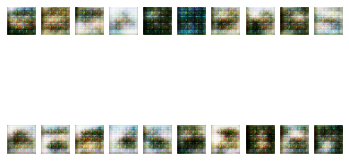

Epoch [1]/[50], D Loss:0.30181941390037537, G Loss:2.7950587272644043
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 1.0, 'second': 47}
Epoch [2]/[50], D Loss:0.3292878270149231, G Loss:3.1044366359710693
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 2.0, 'second': 40}
Epoch [3]/[50], D Loss:0.3518182337284088, G Loss:2.8037562370300293
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 3.0, 'second': 33}
Epoch [4]/[50], D Loss:0.3494669497013092, G Loss:2.7745392322540283
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 4.0, 'second': 26}
Epoch [5]/[50], D Loss:0.3415948450565338, G Loss:2.813751220703125
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 5.0, 'second': 19}


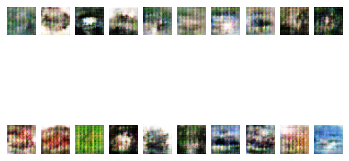

Epoch [6]/[50], D Loss:0.369771271944046, G Loss:2.6738882064819336
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 6.0, 'second': 13}
Epoch [7]/[50], D Loss:0.3438241481781006, G Loss:2.665618419647217
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 7.0, 'second': 6}
Epoch [8]/[50], D Loss:0.33476588129997253, G Loss:2.6065993309020996
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 7.0, 'second': 59}
Epoch [9]/[50], D Loss:0.3443912863731384, G Loss:2.4738831520080566
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 8.0, 'second': 52}
Epoch [10]/[50], D Loss:0.35659337043762207, G Loss:2.4473373889923096
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 9.0, 'second': 45}


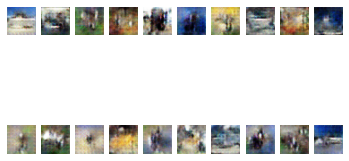

Epoch [11]/[50], D Loss:0.34924790263175964, G Loss:2.2890968322753906
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 10.0, 'second': 39}
Epoch [12]/[50], D Loss:0.354947030544281, G Loss:2.2938873767852783
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 11.0, 'second': 32}
Epoch [13]/[50], D Loss:0.3510386049747467, G Loss:2.207534074783325
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 12.0, 'second': 24}
Epoch [14]/[50], D Loss:0.3853694796562195, G Loss:2.197598695755005
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 13.0, 'second': 17}
Epoch [15]/[50], D Loss:0.3671744465827942, G Loss:2.0955395698547363
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 14.0, 'second': 10}


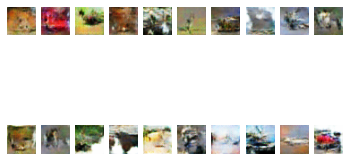

Epoch [16]/[50], D Loss:0.37874266505241394, G Loss:2.1366801261901855
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 15.0, 'second': 4}
Epoch [17]/[50], D Loss:0.3762163519859314, G Loss:2.0696234703063965
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 15.0, 'second': 57}
Epoch [18]/[50], D Loss:0.37691283226013184, G Loss:2.0860674381256104
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 16.0, 'second': 50}
Epoch [19]/[50], D Loss:0.3899769186973572, G Loss:2.067105293273926
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 17.0, 'second': 43}
Epoch [20]/[50], D Loss:0.37531909346580505, G Loss:1.9640729427337646
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 18.0, 'second': 36}


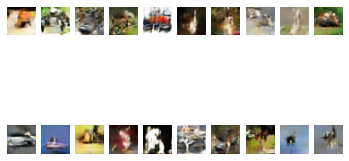

Epoch [21]/[50], D Loss:0.4099523723125458, G Loss:2.046743154525757
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 19.0, 'second': 30}
Epoch [22]/[50], D Loss:0.4058924615383148, G Loss:1.9649486541748047
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 20.0, 'second': 24}
Epoch [23]/[50], D Loss:0.3645703196525574, G Loss:1.9101217985153198
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 21.0, 'second': 17}
Epoch [24]/[50], D Loss:0.4341078996658325, G Loss:1.97359299659729
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 22.0, 'second': 10}
Epoch [25]/[50], D Loss:0.3635116517543793, G Loss:1.8880631923675537
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 23.0, 'second': 3}


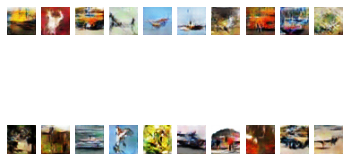

Epoch [26]/[50], D Loss:0.4358879327774048, G Loss:1.8959757089614868
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 23.0, 'second': 57}
Epoch [27]/[50], D Loss:0.38861098885536194, G Loss:1.8613169193267822
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 24.0, 'second': 50}
Epoch [28]/[50], D Loss:0.41089192032814026, G Loss:1.8885040283203125
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 25.0, 'second': 43}
Epoch [29]/[50], D Loss:0.4203125238418579, G Loss:1.9164918661117554
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 26.0, 'second': 36}
Epoch [30]/[50], D Loss:0.4042132794857025, G Loss:1.8866747617721558
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 27.0, 'second': 29}


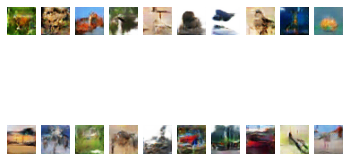

Epoch [31]/[50], D Loss:0.35991615056991577, G Loss:1.8661597967147827
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 28.0, 'second': 23}
Epoch [32]/[50], D Loss:0.4435012936592102, G Loss:1.887036919593811
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 29.0, 'second': 16}
Epoch [33]/[50], D Loss:0.3556537628173828, G Loss:1.8677079677581787
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 30.0, 'second': 9}
Epoch [34]/[50], D Loss:0.3814004063606262, G Loss:1.91487717628479
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 31.0, 'second': 2}
Epoch [35]/[50], D Loss:0.42830154299736023, G Loss:1.9553545713424683
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 31.0, 'second': 55}


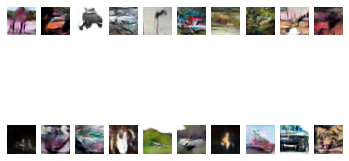

Epoch [36]/[50], D Loss:0.3808049261569977, G Loss:1.9033210277557373
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 32.0, 'second': 49}
Epoch [37]/[50], D Loss:0.3630184233188629, G Loss:1.9206938743591309
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 33.0, 'second': 42}
Epoch [38]/[50], D Loss:0.3924168348312378, G Loss:1.9465583562850952
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 34.0, 'second': 35}
Epoch [39]/[50], D Loss:0.3707978427410126, G Loss:1.9480005502700806
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 35.0, 'second': 28}
Epoch [40]/[50], D Loss:0.38758283853530884, G Loss:1.936720609664917
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 36.0, 'second': 21}


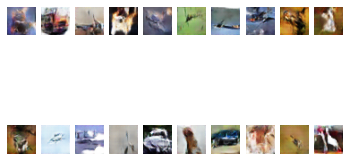

Epoch [41]/[50], D Loss:0.3728067874908447, G Loss:1.933234691619873
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 37.0, 'second': 15}
Epoch [42]/[50], D Loss:0.39153972268104553, G Loss:1.9896256923675537
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 38.0, 'second': 8}
Epoch [43]/[50], D Loss:0.33321690559387207, G Loss:1.954959511756897
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 39.0, 'second': 2}
Epoch [44]/[50], D Loss:0.36027419567108154, G Loss:2.034301280975342
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 39.0, 'second': 55}
Epoch [45]/[50], D Loss:0.3749582767486572, G Loss:2.045912265777588
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 40.0, 'second': 48}


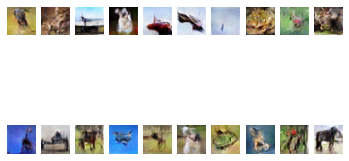

Epoch [46]/[50], D Loss:0.3191378712654114, G Loss:2.044971466064453
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 41.0, 'second': 42}
Epoch [47]/[50], D Loss:0.3913309872150421, G Loss:2.0466017723083496
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 42.0, 'second': 35}
Epoch [48]/[50], D Loss:0.38974729180336, G Loss:2.090052604675293
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 43.0, 'second': 28}
Epoch [49]/[50], D Loss:0.33647432923316956, G Loss:2.0589711666107178
cost time: {'day': 0.0, 'hour': 0.0, 'minute': 44.0, 'second': 21}


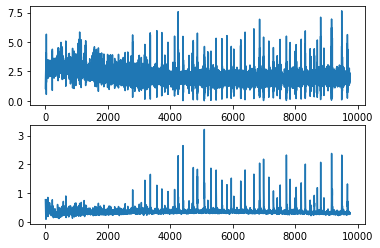

In [19]:
if __name__ == '__main__':
    train_network = Network(dataset='cifar10')
    train_network.train_cifar10()